# Task 4

## Subtask 1

Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
import matplotlib.gridspec as gridspec
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Choosing the device as GPU if available, and CPU if not.
Defined the function to factorize a given matrix into W and H

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def factorize(A, r, device):
    A = A.to(device)
    #randomly initializing W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    diff_matrix = torch.mm(W, H) - A
    diff_vector = diff_matrix[mask]
    prev_loss = torch.norm(diff_vector)+1
    first_iter = 1
    while True:
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        if ((prev_loss == loss)):
            break
        prev_loss = loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return W, H, loss

Reading image

In [5]:
import torchvision
img = torchvision.io.read_image("task_4_image.jpeg")
print(img.shape)

torch.Size([3, 1200, 1920])


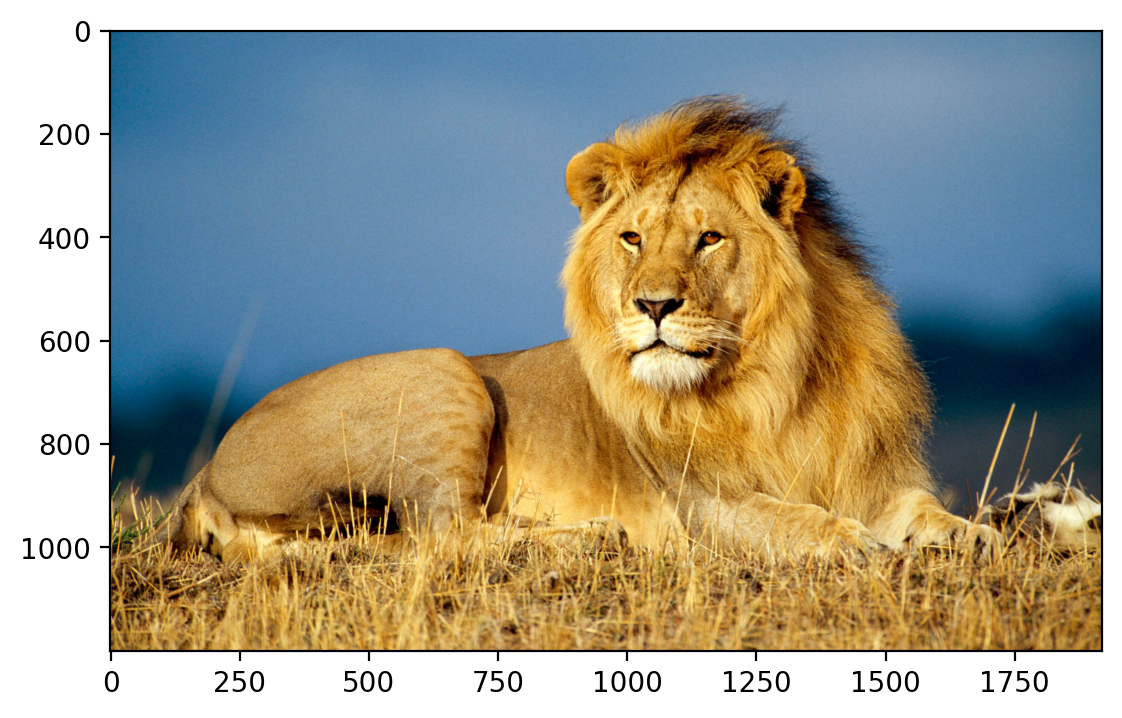

In [6]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

torch.Size([3, 500, 500])


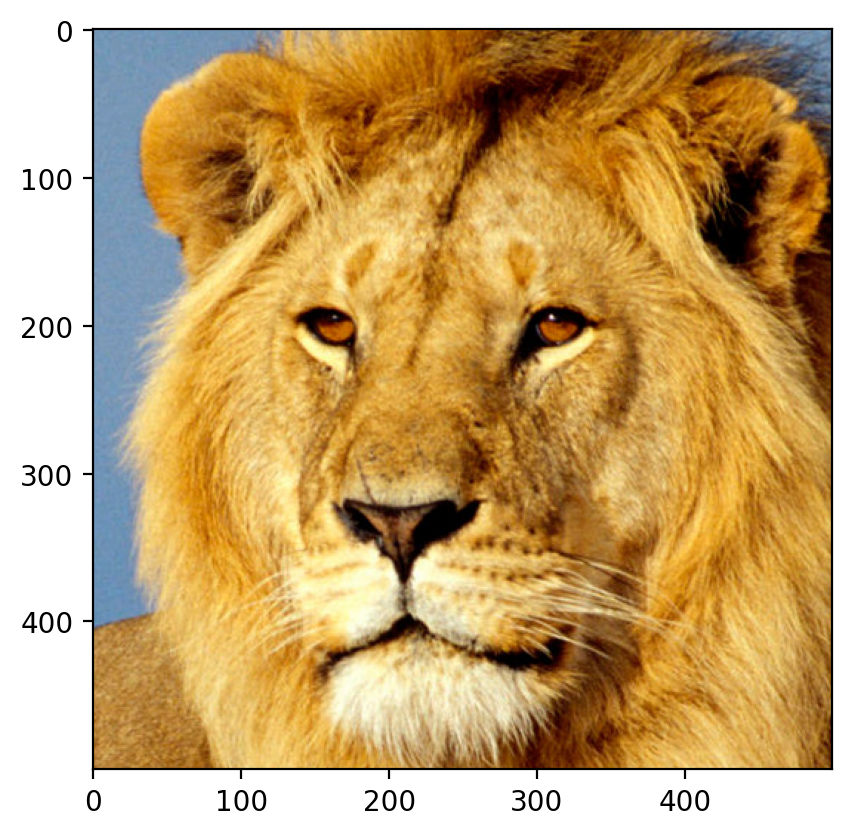

In [7]:
crop = torchvision.transforms.functional.crop(img, 200, 850, 500, 500)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').numpy())

Factorizing each of the 3 channels individually

In [8]:
W0, H0, loss = factorize(crop[0], 50, device=device)
W1, H1, loss = factorize(crop[1], 50, device=device)
W2, H2, loss = factorize(crop[2], 50, device=device)

In [9]:
arr0 = torch.mm(W0, H0).cpu().detach().numpy()
arr1 = torch.mm(W1, H1).cpu().detach().numpy()
arr2 = torch.mm(W2, H2).cpu().detach().numpy()
arr0 = np.clip(arr0, 0, 255)
arr1 = np.clip(arr1, 0, 255)
arr2 = np.clip(arr2, 0, 255)

C:\Users\jainm\AppData\Local\Temp\ipykernel_30316\3576662207.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  reimg50 = torch.Tensor([arr0, arr1, arr2])


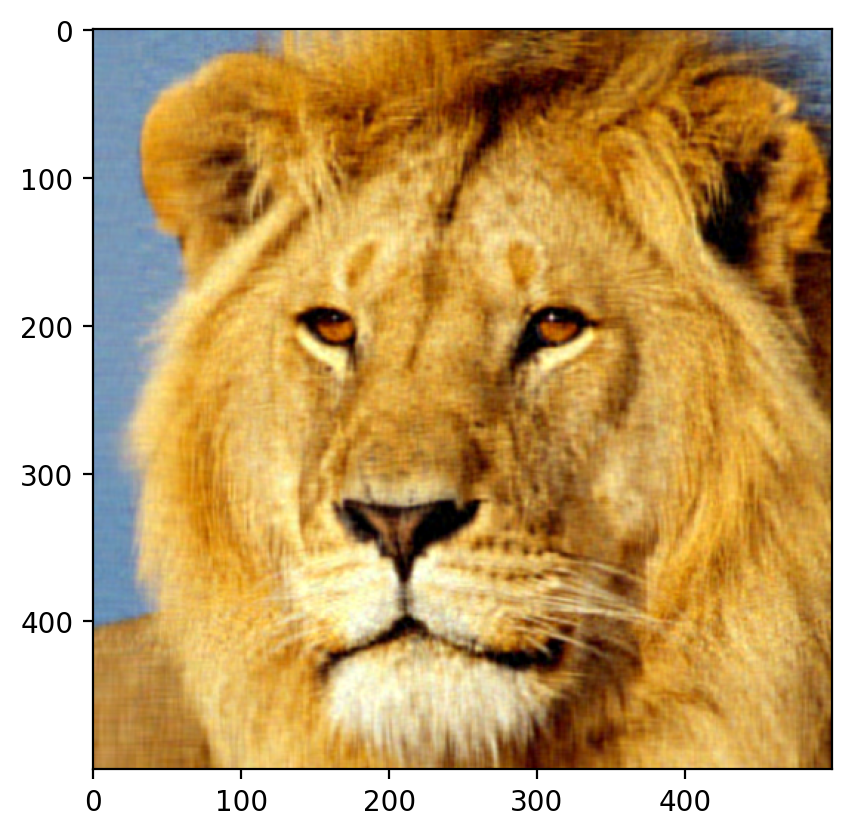

In [10]:
reimg50 = torch.Tensor([arr0, arr1, arr2])
plt.imshow(rearrange(reimg50, 'c h w -> h w c').numpy().astype(np.uint8))

Factorizing again with higher r

In [11]:
W02, H02, loss = factorize(crop[0], 200, device=device)

In [12]:
W12, H12, loss = factorize(crop[1], 200, device=device)

In [13]:
W22, H22, loss = factorize(crop[2], 200, device=device)

In [14]:
arr0 = torch.mm(W02, H02).cpu().detach().numpy()
arr1 = torch.mm(W12, H12).cpu().detach().numpy()
arr2 = torch.mm(W22, H22).cpu().detach().numpy()
arr0 = np.clip(arr0, 0, 255)
arr1 = np.clip(arr1, 0, 255)
arr2 = np.clip(arr2, 0, 255)

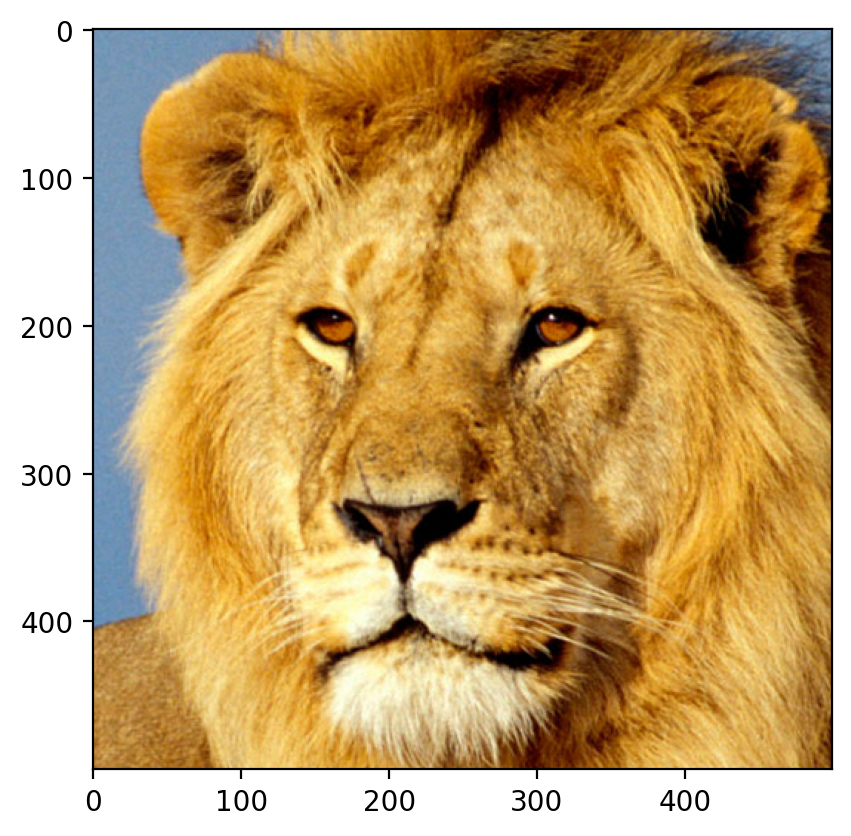

In [15]:
reimg200 = torch.Tensor([arr0, arr1, arr2])
plt.imshow(rearrange(reimg200, 'c h w -> h w c').numpy().astype(np.uint8))

Text(0.5, 1.0, 'Reconstructed image with r=200')

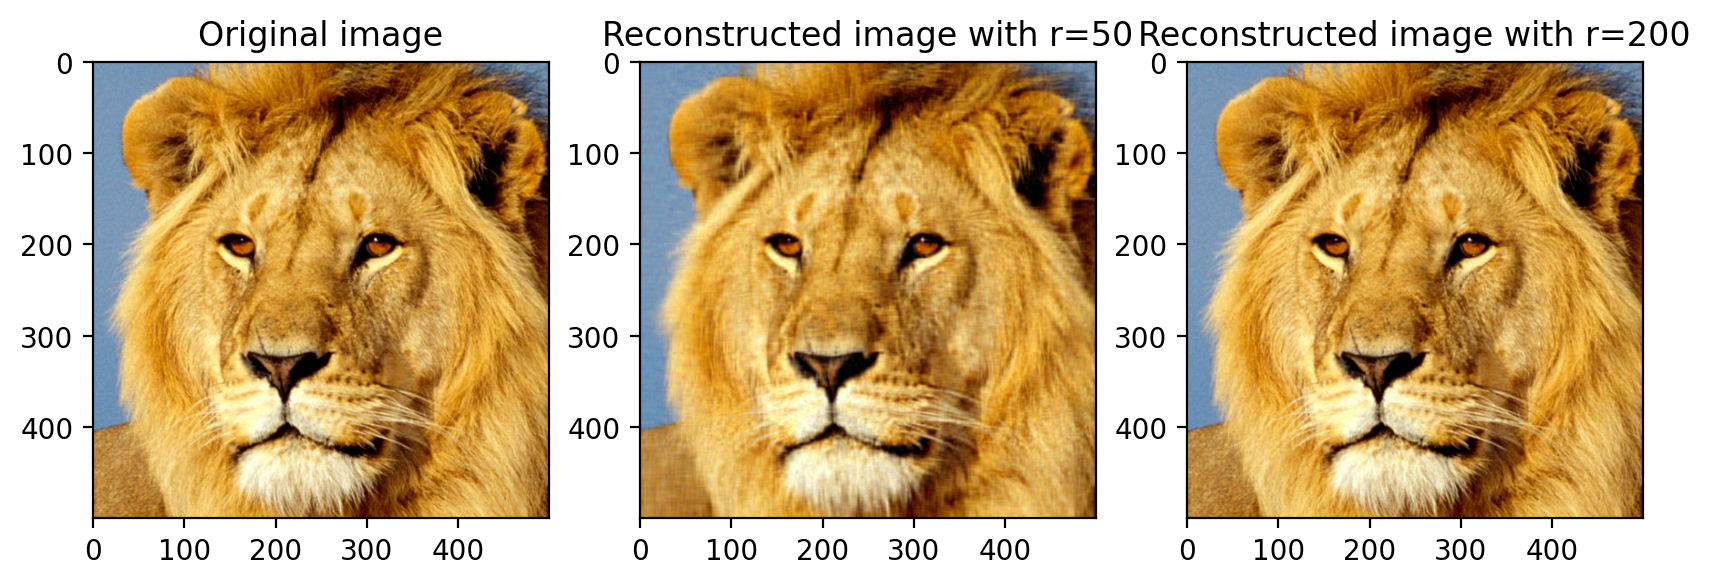

In [16]:
#comparing the reconstructed image with the original image
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(rearrange(crop, 'c h w -> h w c').numpy().astype(np.uint8))
ax[0].set_title("Original image")
ax[1].imshow(rearrange(reimg50, 'c h w -> h w c').numpy().astype(np.uint8))
ax[1].set_title("Reconstructed image with r=50")
ax[2].imshow(rearrange(reimg200, 'c h w -> h w c').numpy().astype(np.uint8))
ax[2].set_title("Reconstructed image with r=200")

Defining functions to calculate RMSE and PSNR

In [17]:
def cal_rmse(original_image, reconstructed_image):
    original_image = original_image.astype(np.float32)
    reconstructed_image = reconstructed_image.astype(np.float32)

    mse = np.mean((original_image-reconstructed_image)**2)
    rmse = np.sqrt(mse)
    return rmse

def cal_psnr(original_image, reconstructed_img):
    rmse = cal_rmse(original_image, reconstructed_img)
    psnr = 20 * np.log10(255.0/rmse)
    return psnr

In [18]:
rmse = cal_rmse(crop.cpu().detach().numpy(), reimg50.cpu().detach().numpy())
psnr = cal_psnr(crop.cpu().detach().numpy(), reimg50.cpu().detach().numpy())
print("For r = 50:")
print("RMSE = ", rmse, " PSNR = ", psnr)
rmse = cal_rmse(crop.cpu().detach().numpy(), reimg200.cpu().detach().numpy())
psnr = cal_psnr(crop.cpu().detach().numpy(), reimg200.cpu().detach().numpy())
print("For r = 200:")
print("RMSE = ", rmse, " PSNR = ", psnr)

For r = 50:
RMSE =  9.4527025  PSNR =  28.619683792530317
For r = 200:
RMSE =  1.7874265  PSNR =  43.0862398980958


## Subtask 2

torch.Size([3, 200, 200])


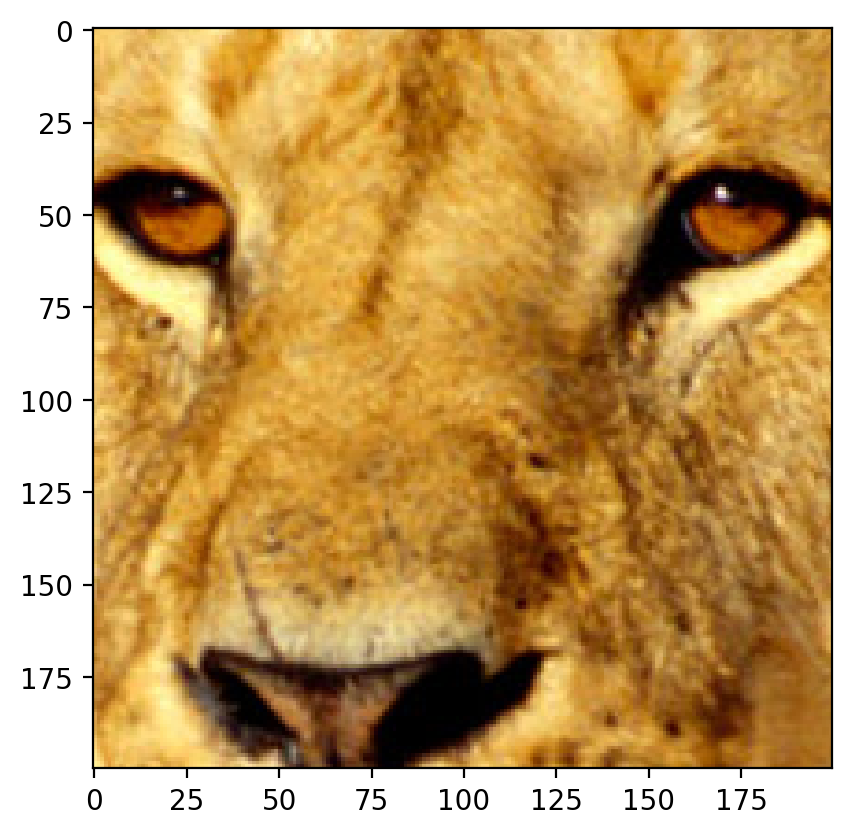

In [19]:
crop = torchvision.transforms.functional.crop(img, 350, 990, 200, 200)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').numpy())

Defining function to mask an image

In [20]:
#function to mask the image with NaN values 
def mask_image(img, prop):
    img = torch.Tensor(img.numpy().astype(np.float32))
    img_copy0 = img[0].clone()
    img_copy1 = img[1].clone()
    img_copy2 = img[2].clone()
    img = torch.Tensor(img.numpy().astype(np.uint8))
    mask = torch.rand(img[0].shape) < prop
    img_copy0[mask] = float('nan')
    img_copy1[mask] = float('nan')
    img_copy2[mask] = float('nan')
    return torch.stack([img_copy0, img_copy1, img_copy2], dim=0)

Masking the image with 2.25% pixels masked (Since, we require 900 out of 200*200 pixels masked)

C:\Users\jainm\AppData\Local\Temp\ipykernel_30316\1255398614.py:2: RuntimeWarning: invalid value encountered in cast
  plt.imshow(rearrange(masked_img, 'c h w -> h w c').numpy().astype(np.uint8))


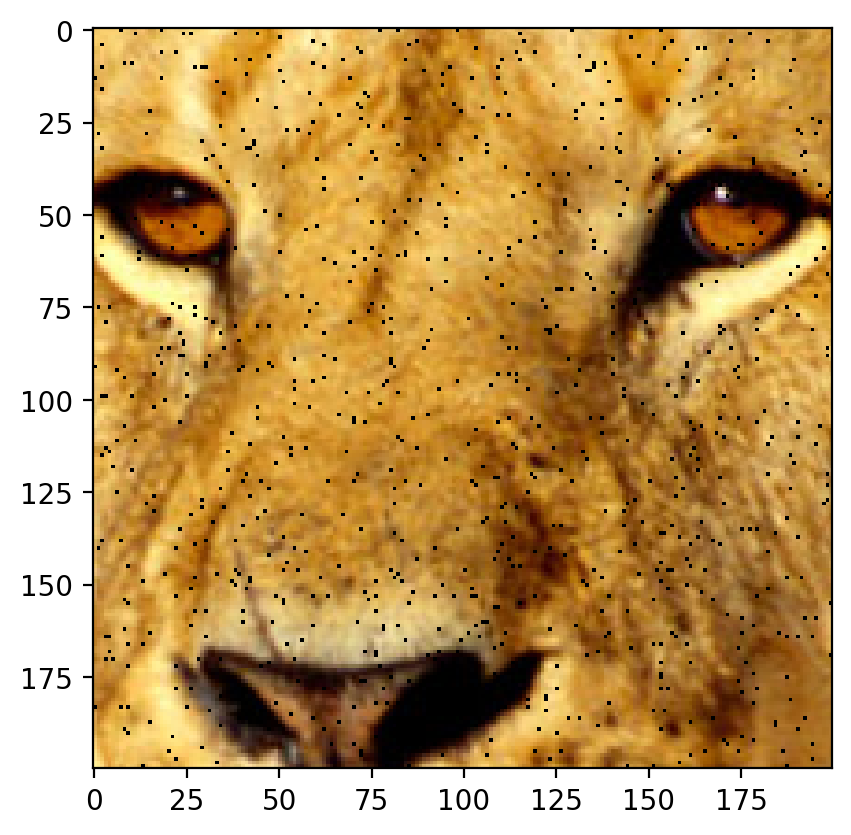

In [21]:
masked_img = mask_image(crop, 0.0225)
plt.imshow(rearrange(masked_img, 'c h w -> h w c').numpy().astype(np.uint8))

Reconstructing using Matrix Factorization

In [22]:
mW0, mH0, loss0 = factorize(masked_img[0], 100, device=device)

In [23]:
mW1, mH1, loss1 = factorize(masked_img[1], 100, device=device)

In [24]:
mW2, mH2, loss2 = factorize(masked_img[2], 100, device=device)

In [25]:
arr0 = torch.mm(mW0, mH0).cpu().detach().numpy()
arr1 = torch.mm(mW1, mH1).cpu().detach().numpy()
arr2 = torch.mm(mW2, mH2).cpu().detach().numpy()
arr0 = np.clip(arr0, 0, 255)
arr1 = np.clip(arr1, 0, 255)
arr2 = np.clip(arr2, 0, 255)

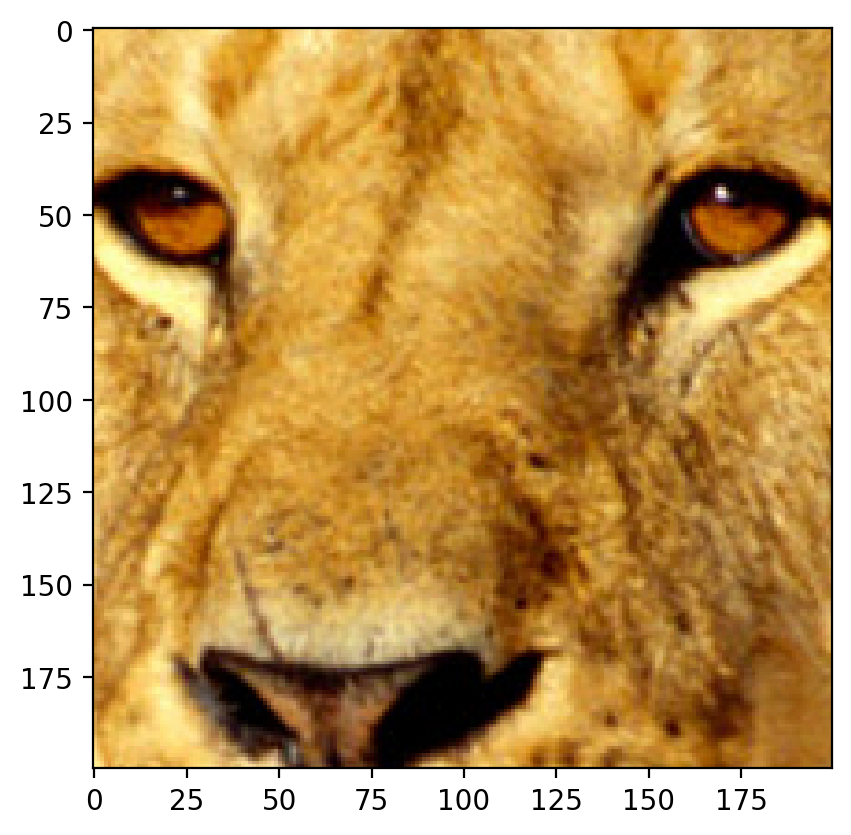

In [26]:
reimg = torch.Tensor([arr0, arr1, arr2])
plt.imshow(rearrange(reimg, 'c h w -> h w c').numpy().astype(np.uint8))

In [27]:
rmse = cal_rmse(crop.cpu().detach().numpy(), reimg.cpu().detach().numpy())
psnr = cal_psnr(crop.cpu().detach().numpy(), reimg.cpu().detach().numpy())
print("RMSE = ", rmse, " PSNR = ", psnr)

RMSE =  1.2234424  PSNR =  46.37913280897406


Reconstructing using Linear Regression and RFF

In [28]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [29]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 1200, 1920])

In [30]:
img_scaled = img_scaled.to(device)

torch.Size([3, 200, 200])


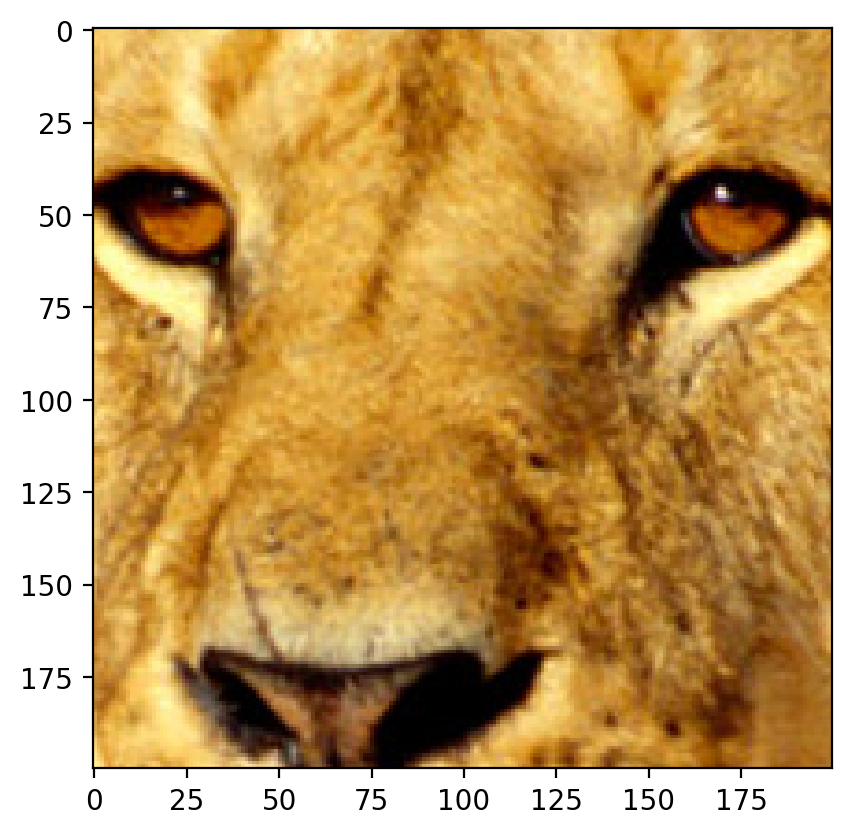

In [31]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 350, 990, 200, 200)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop = crop.to(device)

In [32]:
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 200 200


In [33]:
def create_coordinate_map(img):
    
    num_channels, height, width = img.shape                 #extracting number of channels, height and width of the img
    
    #creating a 2D grid of (x,y) coordinates (h, w)
   
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    
    #flatening and combining the coordinates 
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float()

    #move X to GPU if available for faster computations
    X = X.to(device)

    #reshaping the image
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [34]:
image_X, image_Y = create_coordinate_map(crop)
image_X.shape, image_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [35]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(image_X.cpu())

#scaling the X coordinates
image_X_scaled = scaler_X.transform(image_X.cpu())

#moving the scaled X coordinates to the GPU
image_X_scaled = torch.tensor(image_X_scaled).to(device)

#setting to dtype float32
image_X_scaled = image_X_scaled.float()

In [36]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [37]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [38]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [39]:
train(net, 0.01, image_X_scaled, image_Y, 1000)

Epoch 0 loss: 0.608752
Epoch 100 loss: 0.041833
Epoch 200 loss: 0.033304
Epoch 300 loss: 0.033298
Epoch 400 loss: 0.033298
Epoch 500 loss: 0.033298
Epoch 600 loss: 0.033298
Epoch 700 loss: 0.033298
Epoch 800 loss: 0.033298
Epoch 900 loss: 0.033298


0.033297888934612274

In [40]:
#creating RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [70]:
X_rff = create_rff_features(image_X_scaled, 18000, 0.008)
X_rff.shape

torch.Size([40000, 18000])

In [71]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.0001, X_rff, image_Y, 1000)

Epoch 0 loss: 0.318001
Epoch 100 loss: 0.306284
Epoch 200 loss: 0.295143
Epoch 300 loss: 0.284482
Epoch 400 loss: 0.274246
Epoch 500 loss: 0.264399
Epoch 600 loss: 0.254913
Epoch 700 loss: 0.245766
Epoch 800 loss: 0.236941
Epoch 900 loss: 0.228420


0.2202720046043396

C:\Users\jainm\AppData\Local\Temp\ipykernel_30316\3491310412.py:11: RuntimeWarning: invalid value encountered in cast
  ax[1].imshow(rearrange(masked_img, 'c h w -> h w c').numpy().astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RFF features')

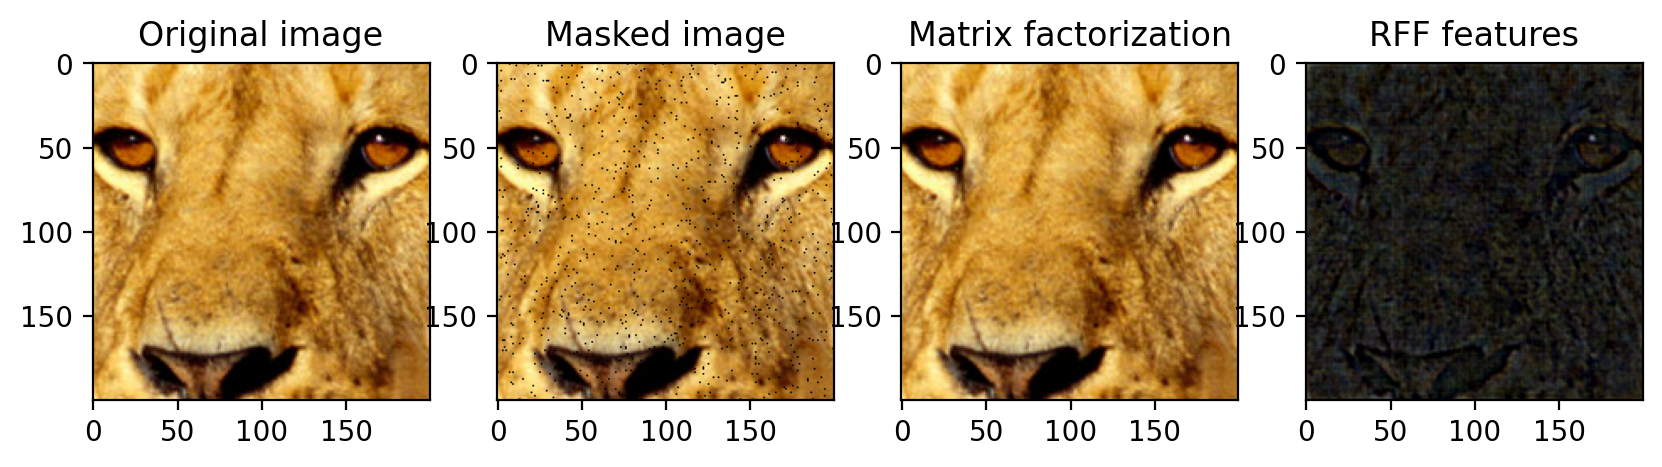

In [72]:
#comparing the reconstructed image by matrix factorization and RFF features with the original image and masked image
num_channels, height, width = crop.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(height, width, num_channels)
    
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
ax[0].set_title("Original image")
ax[1].imshow(rearrange(masked_img, 'c h w -> h w c').numpy().astype(np.uint8))
ax[1].set_title("Masked image")
ax[2].imshow(rearrange(reimg, 'c h w -> h w c').numpy().astype(np.uint8))
ax[2].set_title("Matrix factorization")
ax[3].imshow(outputs.cpu())
ax[3].set_title("RFF features")

In [73]:
rmse = cal_rmse((crop*256).cpu().detach().numpy(), reimg.cpu().detach().numpy())
psnr = cal_psnr((crop*256).cpu().detach().numpy(), reimg.cpu().detach().numpy())
print("For reconstructed image by Matrix Factorization:")
print("RMSE = ", rmse, " PSNR = ", psnr)
rmse = cal_rmse((crop*256).cpu().detach().numpy(), (rearrange(outputs, 'h w c -> c h w')*256).cpu().detach().numpy())
psnr = cal_psnr((crop*256).cpu().detach().numpy(), (rearrange(outputs, 'h w c -> c h w')*256).cpu().detach().numpy())
print("For reconstructed image using RFF features")
print("RMSE = ", rmse, " PSNR = ", psnr)

For reconstructed image by Matrix Factorization:
RMSE =  1.3504972  PSNR =  45.520929552242194
For reconstructed image using RFF features
RMSE =  120.126785  PSNR =  6.538006507819406
